In [13]:
import torch
import torch.nn as nn
from torch.nn import Module
from typing import Dict, overload, TypeVar, Union, Iterator
from collections import OrderedDict
import operator
from itertools import islice
from torch._jit_internal import _copy_to_script_wrapper
from torch.nn.modules.container import Sequential
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# Synthetic Dataset
N = 1000
X = np.random.random((N, 2)) * 6 - 3 # Uniformly distributed between -3 and 3
Y = np.cos(2*X[:, 0]) + np.cos(3*X[:, 1])

In [9]:
# Custom nn.Sequential class

class MySequential(Module):
  
  _module = Dict[str, Module]
  T = TypeVar('T', bound=Module)

  @overload
  def __init__(self, *args:Module) -> None:
    ...
  
  @overload
  def __init__(self, arg:'OrderedDict[str, Module]') -> None:
    ...
  
  def __init__(self, *args):
    super(MySequential, self).__init__()
    if len(args) == 1 and isinstance(args[0], OrderedDict):
      for key, module in args[0].items():
        self.add_module(key, module)
    else:
      for idx, module in enumerate(args):
        self.add_module(str(idx), module)
  
  def _get_item_by_idx(self, iterator, idx) -> T:
    size = len(self)
    idx = operator.index(idx)
    if not -size <= idx < size:
      raise IndexError(f"index {idx} is out of range")
    idx %= size
    return next(islice(iterator, idx, None))
  
  @_copy_to_script_wrapper
  def __getitem__(self, idx:Union[slice, int]) -> Union["MySequential", T]:
    if isinstance(idx, slice):
      return self.__class__(OrderedDict(list(self._modules.items())[idx]))
    else:
      return self._get_item_by_idx(self._modules.values(), idx)

  def __setitem__(self, idx:int, module:Module) -> None:
    key: str = self._get_item_by_idx(self._modules.values(), idx)
    return setattr(self, key, module)
  
  def __delitem__(self, idx:Union[slice, int]) -> None:
    if isinstance(idx, slice):
      for key in list(self._modules.keys())[idx]:
        delattr(self, key)
    else:
      key = self._get_item_by_idx(self._modules.keys(), idx)
      delattr(self, key)
  
    str_indices = [str(i) for i in range(len(self._modules))]
    self._modules = OrderedDict(list(zip(str_indices, self._modules.values())))
  
  @_copy_to_script_wrapper
  def __len__(self) -> int:
    return len(self._modules)
  
  def __add__(self, other) -> 'MySequential':
    if isinstance(other, MySequential):
      ret = MySequential()
      for layer in self:
        ret.append(layer)
      for layer in other:
        ret.append(layer)
      return ret
    else:
      raise ValueError(f'add operator supports only objects of MySequential class, but {type(other)} is given.') 
  
  def pop(self, key:Union[int, slice]) -> Module:
    v = self[key]
    del self[key]
    return v

  def __iadd__(self, other) -> 'MySequential':
    if isinstance(other, MySequential):
      offset = len(self)
      for i, module in enumerate(other):
        self.add_module(str(i + offset), module)
      return self
    else:
      raise ValueError(f'add operator supports only objects of MySequential class, but {type(other)} is given.')
  
  def __mul__(self, other:int) -> 'MySequential':
    if not isinstance(other, int):
      raise TypeError(f"unsupported operand type(s) for *: {type(self)} and {type(other)}")
    elif other <= 0:
      raise ValueError(f"Non-positive multiplication factor {other} for {type(self)}")
    else:
      combined = MySequential()
      offset = 0
      for _ in range(other):
        for module in self:
          combined.add_module(str(offset), module)
          offset += 1
      return combined

  def __rmul__(self, other:int) -> 'MySequential':
    return self.__mul__(other)
  
  def __imul__(self, other:int) -> 'MySequential':
    if not isinstance(other, int):
      raise TypeError(f"unsupported operand type(s) for *: {type(self)} and {type(other)}")
    elif other <= 0:
      raise ValueError(f"Non-positive multiplication factor {other} for {type(self)}")
    else:
      len_original = len(self)
      offset = len(self)
      for _ in range(other - 1):
        for i in range(len_original):
          self.add_module(str(i + offset), self._modules[str(i)])
        offset += len_original
      return self
  
  @_copy_to_script_wrapper
  def __dir__(self):
    keys = super(MySequential, self).__dir__()
    keys = [key for key in keys if not key.isdigit()]
    return keys

  @_copy_to_script_wrapper
  def __iter__(self) -> Iterator[Module]:
    return iter(self._modules.values())
  
  def forward(self, input):
    for module in self:
      input = module(input)
    return input

  def append(self, module:Module) -> 'MySequential':
    self.add_module(str(len(self)), module)
    return self
  
  def insert(self, index:int, module:Module) -> 'MySequential':
    if not isinstance(module, Module):
      raise AssertionError(f"module should be of type: {Module}")
    n = len(self._modules)
    if not -n <= index < n:
      raise IndexError(f"Index out of range {index}")
    if index < 0:
      index += n
    for i in range(n, index, -1):
      self._modules[str(i)] = self._modules[str(i - 1)]
    self._modules[str(index)] = module
    return self

  def extend(self, my_sequential) -> 'MySequential':
    for layer in my_sequential:
      self.append(layer)
    return self

In [10]:
# Build the model
model = MySequential(
    nn.Linear(2, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
)

In [11]:
# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [12]:
# Train the model
def full_gd(model, criterion, optimizer, X_train, Y_train, epochs=1000):
  train_losses = np.zeros(epochs)

  for i in range(epochs):
    # zero the parameter gradients
    optimizer.zero_grad()

    # Forward Pass
    outputs = model(X_train)
    loss = criterion(outputs, Y_train)

    # Backward and Optimize
    loss.backward()
    optimizer.step()

    train_losses[i] = loss.item()

    if (i + 1) % 50 == 0:
      print(f"Epoch {i+1} / {epochs}, Train Loss: {loss.item():.4f}")

  return train_losses

X_train = torch.from_numpy(X.astype(np.float32))
Y_train = torch.from_numpy(Y.astype(np.float32).reshape(-1, 1))
train_losses = full_gd(model, criterion, optimizer, X_train, Y_train)

Epoch 50 / 1000, Train Loss: 0.5948
Epoch 100 / 1000, Train Loss: 0.3203
Epoch 150 / 1000, Train Loss: 0.2004
Epoch 200 / 1000, Train Loss: 0.0949
Epoch 250 / 1000, Train Loss: 0.0325
Epoch 300 / 1000, Train Loss: 0.0127
Epoch 350 / 1000, Train Loss: 0.0070
Epoch 400 / 1000, Train Loss: 0.0052
Epoch 450 / 1000, Train Loss: 0.0060
Epoch 500 / 1000, Train Loss: 0.0037
Epoch 550 / 1000, Train Loss: 0.0036
Epoch 600 / 1000, Train Loss: 0.0033
Epoch 650 / 1000, Train Loss: 0.0027
Epoch 700 / 1000, Train Loss: 0.0029
Epoch 750 / 1000, Train Loss: 0.0024
Epoch 800 / 1000, Train Loss: 0.0117
Epoch 850 / 1000, Train Loss: 0.0022
Epoch 900 / 1000, Train Loss: 0.0041
Epoch 950 / 1000, Train Loss: 0.0021
Epoch 1000 / 1000, Train Loss: 0.0029


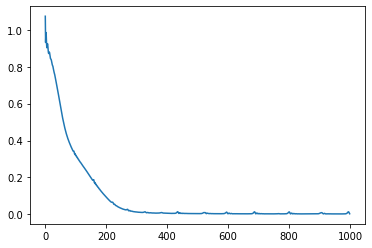

In [14]:
plt.plot(train_losses);